In [6]:
import nibabel as nib
import numpy as np
from sklearn.linear_model import Lasso,LassoCV,LinearRegression,Ridge
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.gaussian_process import GaussianProcessRegressor,GaussianProcess
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor

from orelmisc import n_max,n_test_max,testpre,trainpre,saveCSV,y_org,shape_3d_org
from preprocess import flatten,flatten_each_sample,loadData,flatten_each_sample,precompute_and_save

In [7]:
prep = lambda i: i # int(i)
# don't round to the nearest integer anymore.
# it seems we can submit floating-point age xD HAHA... ... I should have tried this out before...
# ... But it seems that itdoesn't actually affect the score ... (changes in 0.05...)

x_org = None
x_t_org = None
xa_org = None
d_org = None
y = y_org
y_t_pred = None
y_t_pp = None
y_best = [59.82692307692308, 75.538461538461533, 52.153846153846153, 81.865384615384613, 79.269230769230774, 76.230769230769226, 51.67307692307692, 52.519230769230766, 67.59615384615384, 55.28846153846154, 21.826923076923077, 54.230769230769234, 72.211538461538467, 30.0, 22.942307692307693, 67.557692307692307, 23.192307692307693, 77.538461538461533, 82.788461538461533, 83.615384615384613, 80.230769230769226, 23.25, 67.057692307692307, 82.807692307692307, 71.57692307692308, 44.32692307692308, 70.615384615384613, 20.884615384615383, 22.403846153846153, 31.71153846153846, 74.788461538461533, 42.192307692307693, 20.26923076923077, 23.096153846153847, 21.634615384615383, 58.519230769230766, 80.40384615384616, 79.07692307692308, 65.65384615384616, 83.519230769230774, 45.557692307692307, 72.07692307692308, 85.788461538461533, 33.942307692307693, 61.153846153846153, 65.384615384615387, 47.42307692307692, 23.25, 23.826923076923077, 64.90384615384616, 24.51923076923077, 77.92307692307692, 21.0, 53.115384615384613, 25.923076923076923, 87.211538461538467, 75.769230769230774, 76.34615384615384, 21.75, 38.596153846153847, 63.884615384615387, 75.17307692307692, 51.596153846153847, 56.653846153846153, 23.576923076923077, 33.884615384615387, 23.653846153846153, 26.923076923076923, 77.634615384615387, 82.442307692307693, 77.75, 77.25, 20.5, 21.673076923076923, 74.42307692307692, 76.0, 52.115384615384613, 64.42307692307692, 67.115384615384613, 31.23076923076923, 70.365384615384613, 78.365384615384613, 84.67307692307692, 32.46153846153846, 26.96153846153846, 85.057692307692307, 23.673076923076923, 45.865384615384613, 26.5, 75.34615384615384, 21.653846153846153, 72.980769230769226, 47.980769230769234, 21.51923076923077, 72.980769230769226, 88.461538461538467, 73.40384615384616, 74.365384615384613, 68.211538461538467, 59.769230769230766, 56.346153846153847, 49.115384615384613, 44.17307692307692, 85.557692307692307, 22.923076923076923, 23.03846153846154, 78.115384615384613, 28.846153846153847, 24.384615384615383, 60.846153846153847, 31.28846153846154, 26.21153846153846, 22.96153846153846, 70.90384615384616, 83.0, 25.653846153846153, 77.59615384615384, 69.75, 37.596153846153847, 36.884615384615387, 31.173076923076923, 21.5, 31.673076923076923, 34.153846153846153, 70.5, 28.71153846153846, 43.903846153846153, 54.653846153846153, 23.634615384615383, 82.692307692307693, 21.71153846153846, 38.82692307692308, 21.75, 22.423076923076923, 23.846153846153847, 21.134615384615383, 82.40384615384616, 82.884615384615387]
prefix=None
alpha = 10
result = None
xa = []
x = None
x_t = None

In [14]:
space = 200 # 200 # 50 is smooth, 200 is a bit more noisy

name = "output/mean_var_mean_std_hist"+str(space)+"_idk_"
#fname = "ax_1_2_3_avg_var.npy"
#fname = "mean_std_loghist_scale2.npy"
#fname = "mean_std_hist120_scale1.npy"
#fname = "mean_std_hist500_scale1.npy"
#fname = "statistics_diff_hist200.npy"
fname = "statistics_diff_hist" + str(space) + ".npy"
fnameMeanHist = "mean_hist" + str(space) + ".npy"
#fnameMeanHist = "mean_hist200.npy"

xa = np.load(fname)
x = xa[0:n_max,:]
x_t = xa[n_max:,:]
nPercentiles = 20
bStat = 8
bins = np.linspace(1,1900,space)
sbins = bins[:-1]+(bins[1]-bins[0])/2.0#bins used to plot the data
ds = bStat + nPercentiles + space-1 # sum,sum2,sum3,avg,var,mode, numper of percentiles and histogram
iHist = bStat + nPercentiles
# doStuff(al=870,n_est=900) # BEST ONE!!!!!!!

In [15]:
def myloop(a):
    return (a,a*a,a*a*a)

myloopU = np.frompyfunc(myloop,1,3,dtype=np.float64)

def loadAndPreprocess():
    global d_org,x,x_t,xa,x_org,x_t_org,xa_org
    
    d_org = 6443008
    """if x_org == None:
        x_org = loadData(scale=1,train=True)
        x_t_org = loadData(scale=1,train=False)
        d_org = 88*88*104# 6443008

        xa_org = np.zeros((n_max+n_test_max,d_org))
        xa_org[0:n_max] = x_org
        xa_org[n_max:] = x_t_org
        #xa = np.zeros((n_max+n_test_max,5+space-1))
    
    """
    xa = np.zeros((n_max+n_test_max,ds))
    hists = np.zeros((n_max+n_test_max,space-1))
    
    i = 0
    print "First loop. Calculate basic statistics and the absolute histogram"
    while i < n_max+n_test_max:
      if i % 5 == 0:
        print "Doing i = %s ..." % i
      
      n_i,pre,t_str = (n_max,"set_train/","train") if i < n_max else (n_test_max,"set_test/","test")
      filename = "%s%s_%s.nii" % (pre,t_str,i%n_max+1)
      data = nib.load(filename).get_data()
      #data=xa_org[i]
      sum = 0.0
      sum2 = 0.0
      sum3 = 0.0
      avg = 0.0
      var = 0.0
      data = data.ravel()
      res = myloopU(data)
      sum = np.sum(res[0])
      sum2 = np.sum(res[1])
      sum3 = np.sum(res[2])
      median = np.median(data)
      avg = sum / float(d_org)
      var = sum2 / float(d_org-1) - avg*avg
      hist = np.histogram(data,bins=bins)[0]
      percentiles = np.linspace(0,100,nPercentiles)
      iMax,hMax = max(enumerate(hist),key=lambda x:x[1])
      percs = np.percentile(hist,percentiles)
      xa[i,:bStat] = [sum,sqrt(sum2),pow(sum3,1/3.0),avg,var,iMax,hMax,median]
      xa[i,bStat:iHist] = percs
      hists[i] = hist
      i = i+1
    
    medianHist = np.median(hists[:n_max,:],axis=0)
    
    np.save(fnameMeanHist,medianHist)
    print "Saved median hist into into %s" % fnameMeanHist
    
    print "Second loop. Compute differences to mean-hisgtogram and save matrix"
    i = 0
    while i < n_max+n_test_max:
      xa[i,(bStat+nPercentiles):] = hists[i]-medianHist
      i=i+1
    
    np.save(fname,xa)
    print "Saved into %s" % fname
    x = xa[0:n_max]
    x_t=xa[n_max:]

## SCHLUSSFOLGERUNG: brauche ein isschen mehr sachen als nur diese momente und summen.
# vielleicht ein grobes histogram?
# pures Lasso und SVD+Lasso waren am besten... mit RSS 155...

## SCLUSSFOLGERUNG 2:
# Pures Lasso mit alpha = 750 war gut. RSS 84 ..
# SVD auf das Histogram bringt keinen Mehrwert...
# Das Ergebnis wrde allein durch die Momente und Statistischen Werte erreicht!!
# [sum,sum2,sum2,avg,var]

# SCHLUSSFOLGERUNG 3:
# Pures Lasso auf den statistischen daten und dem histogram. Mit alpha = 870 wurde bis zu RSS 77 erreicht!
# wir sind damit unter der öffentlichen Schranke von 80 angelangt!
  

# Schlussfolgerung 4:
# Ada
    # Lasso
    # Polynomial fitting
    # Default Desicion Tree Estimator was good!!! -> RSS 70

In [16]:
#print y
#loadAndPreprocess()

In [24]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic

def makeGaussianProcess():
  global y_t_pred,result
  prefix = "%s_GP_FULL"%(name)
  #kernel = RBF(1e1,(1e-5,1e7))
  kernel = RationalQuadratic()#(1e1,(1e-5,1e7))
  #kernel = ExpSineSquared()#(1e1,(1e-5,1e7))
  model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9)
  x1 = x[:,3:6:2]
  x_t1 = x_t[:,3:6:2]
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Coefficients: %s" % model.get_params()
  #print "Highest Coefficients: %s" % str(sorted(model.get_params(),key=lambda x:-x))
  print str((model.kernel_, model.log_marginal_likelihood(model.kernel_.theta)))
  return prefix,model

def makeSVDLassoPrediction(comps,al=15):
  global y_t_pred,result,alpha
  alpha = al
  svd = TruncatedSVD(n_components=comps,n_iter=20)
  print "Prediction with alpha = %s" % alpha
  prefix = "%sSVD_Lasso_comps%s_alpha%s_FULL"%(name,comps,alpha)
  #x1 = np.concatenate((x[:,:5],svd.fit_transform(x)),axis=1)
  #x1 = svd.fit_transform(x)
  #x_t1 = svd.transform(x_t)
  #x_t1 = np.concatenate((x_t[:,:5],svd.transform(x_t)),axis=1)
   
  #x1 = x[:,iHist:]; x_t1 = x_t[:,iHist:]
  #x1 = x[:,:iHist]; x_t1 = x_t[:,:iHist]
  x1 = x[:,:]; x_t1 = x_t[:,:] 

  lasso = Lasso(alpha=alpha)
  y_t_pred = lasso.fit(x1,y).predict(x_t1)
  r = lasso.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  print "Coefficients: %s...." % lasso.coef_[:5]
  #print "singular values of x0: %s" % np.sort(x1[0])
  plt.clf()
  plt.plot(np.sort(x1[0]))
  plt.show()
  return prefix,lasso
       
def makeAdaDefaultBaseEstimatorPrediction(n_est):
  global y_t_pred,result
  print "Prediction and #estimators = %s" % (n_est)
  prefix = "%s_AdaBoost_n_est%s_DefaultDecisionTree"%(name,n_est)
  model = AdaBoostRegressor(n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Estimator weights: %s..." % model.estimator_weights_
  bla1 = (sorted(enumerate(model.estimator_weights_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest est-weights: %s..." % bla1
  plt.clf()
  plt.plot(model.estimator_weights_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_est_weights.png")
  plt.show()
  return prefix,model

def makeBaggingBoostDefaultDecisionTreePrediction(n_est):
  global y_t_pred,result
  print "Prediction #estimators = %s and Decision Trees" % (n_est)
  prefix = "%s_BaggingBoost_n_est%s_DefaultTree"%(name,n_est)
  model = BaggingRegressor(n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  return prefix,model

def makeBaggingBoostGaussianProcessPrediction(n_est,maxfs):
  global y_t_pred,result
  print "Prediction #estimators = %s and Gaussian Process" % (n_est)
  prefix = "%s_BaggingBoost_max_features%s_GP"%(name,maxfs)
  
  model = BaggingRegressor(GaussianProcessRegressor(kernel=RationalQuadratic(),n_restarts_optimizer=9),
                           n_estimators=n_est)
                           #,max_features=maxfs,n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  return prefix,model

# use base estimator (decision trees?)
    
def makeAdaLassoPrediction(al,n_est):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s and #estimators = %s" % (alpha,n_est)
  prefix = "%s_AdaBoost_Lasso_alpha%s"%(name,alpha)
  model = AdaBoostRegressor(Lasso(alpha=alpha),n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Estimator weights: %s..." % model.estimator_weights_
  bla1 = (sorted(enumerate(model.estimator_weights_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest est-weights: %s..." % bla1
  plt.clf()
  plt.plot(model.estimator_weights_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_est_weights.png")
  plt.show()
  return prefix,model
    
def makeLassoPrediction(al):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s" % alpha
  prefix = "%s_LassoPure_alpha%s_FULL"%(name,alpha)
  model = Lasso(alpha=alpha)
  x1 = x[:,:iHist] # use all data
  x_t1 = x_t[:,:iHist] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % model.intercept_
  print "Coefficients: %s..." % model.coef_[:5]
  bla1 = (sorted(enumerate(model.coef_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest coefficients: %s..." % bla1
  plt.clf()
  plt.plot(model.coef_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_coefficients.png")
  plt.show()
  return prefix,model

def makeLassoCVPrediction(cv=3):
  global y_t_pred,result
  print "Prediction with cv = %s" % 3
  prefix = "%s_LassoCV_FULL"%(name)
  lasso = LassoCV(cv=cv)
  y_t_pred = lasso.fit(x,y).predict(x_t)
  r = lasso.score(x,y)
  m_log_alphas = -np.log10(lasso.alphas_)
  plt.plot(m_log_alphas, lasso.mse_path_, ':')
  plt.show()
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  #print "Coefficients: %s" % lasso.coef_
  return prefix,lasso


def makeLinearRegression():
  global y_t_pred,result
  prefix = "%s_LinReg_FULL"%(name)
  linreg = LinearRegression()
  y_t_pred = linreg.fit(x,y).predict(x_t)
  r = linreg.score(x,y)
  print("score r = %s"%r)
  print "Intercept: %s" % linreg.intercept_
  print "Coefficients: %s" % linreg.coef_
  print "Residues: %s" % linreg.residues_
  return prefix,linreg

In [27]:
def doStuff(al=15,comps=n_max-1,kernel="rbf",n_est=120,maxfs=2):
  global prefix,result
  #loadAndPreprocess()
  
  #prefix,model = makeLassoPrediction(al=al)
  #prefix,model  = makeAdaDefaultBaseEstimatorPrediction(n_est=n_est)
  #prefix,model = makeAdaLassoPrediction(al=al,n_est=n_est)
  #prefix,model = makeSVDLassoPrediction(al=al,comps=comps)
  #prefix,model = makeLassoCVPrediction(cv=3)
  #prefix,model = makeLinearRegression()
  #prefix,model = makeRidgePrediction(al=al)
  #prefix,model = makeGaussianProcess()
  #prefix,model = makeBaggingBoostDefaultDecisionTreePrediction(n_est=n_est)
  prefix,model = makeBaggingBoostGaussianProcessPrediction(n_est=n_est,maxfs=maxfs)
  #prefix,model = make_KPCA_prediction(kernel=kernel,al=al)
  
  y_t_pp = savePrediction()
  
  visualize(y,y_t_pp,prefix)
  
  print " ========= x ========== \n%s\n" % x
  print " ========= y_t_pp ========== \n%s\n" % y_t_pp
  
  # retuns a colleciton of stuff to return
  print "Variables available in 'result'"
  result = (x,y,x_t,y_t_pred,y_t_pp,model)

def visualize(y,y_t_pp,prefix):
  """ Step 5: make histogram plot of age """
  # (because no visualization for flat data matrix...)
  plt.hist(y,color="black",rwidth=0.7)
  #plt.hist(y_pred,color="darkgreen",rwidth=0.5)
  plt.hist(y_t_pp,color="darkblue",rwidth=0.5)
  plt.legend(["ages given for X",
    #"ages predicted for X",
    "ages predicted for X_t"])
  plt.savefig(prefix + "_histogram_ages.png")
  plt.show()
  plt.clf()
  plt.plot(np.array(y_t_pp)-np.array(y_best),"bo")
  plt.savefig(prefix + "_diff_to_score_61.png")
  plt.show()
  plt.clf()
  plt.plot(sorted(y_t_pp),"bo")
  plt.savefig(prefix + "_sorted.png")
  print("Saved age diagrams as %s"%(prefix+"*.png"))
  plt.show()

def savePrediction():
    global y_t_pp
    y_t_pp = [prep(i) for i in y_t_pred]
    savedFilename = saveCSV(y_t_pp,prefix)
    print("Saved predictions into %s" % savedFilename)
    return y_t_pp

In [28]:
doStuff()

Prediction #estimators = 120 and Gaussian Process


/usr/lib64/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.02789343,  0.01020063]), 'nit': 14, 'funcalls': 57}
  " state: %s" % convergence_dict)


KeyboardInterrupt: 

## Histogram deviation from mean and Lasso coefficients

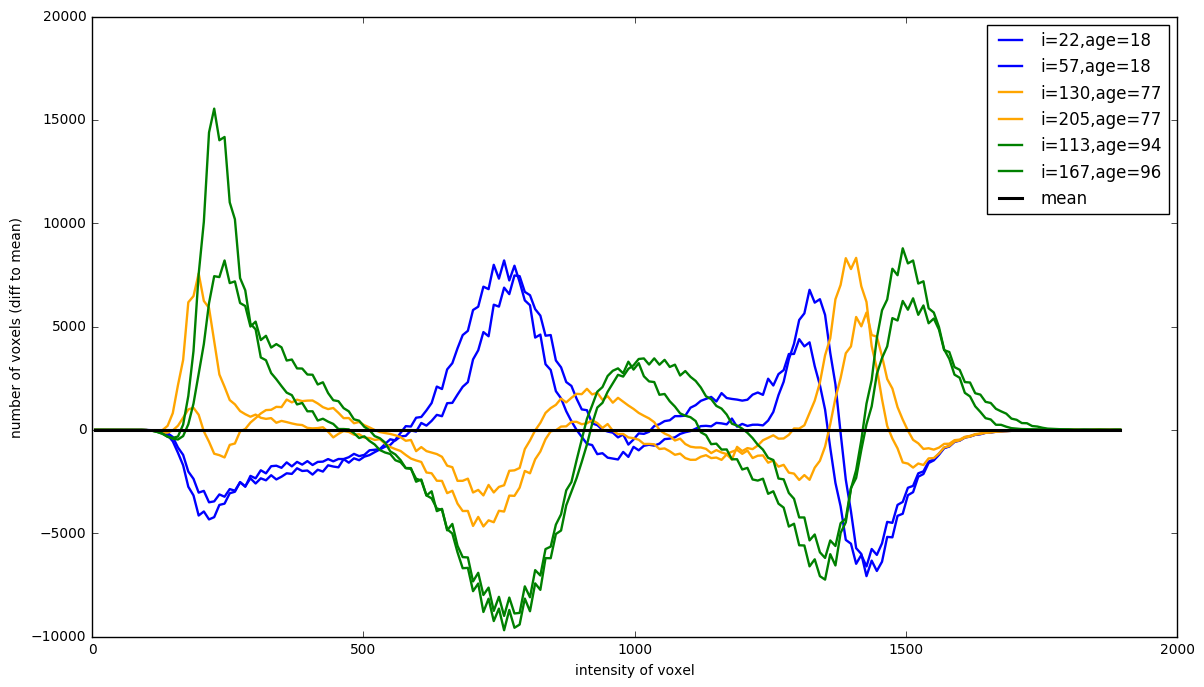

In [90]:
# show various histograms by age. revealing..

# TODO: use median for plotting!!!

plt.clf()
g = "-adaboost-hist" + str(space)
fig = plt.figure(1)
fig.set_size_inches(14,8)
sortI = range(0,n_max)
sortI.sort(key=lambda i:y[i])
for si,i in enumerate(sortI[:2] + sortI[205:207] + sortI[-2:]):
    s = "i=%s,age=%s" % (i,y[i])
    c = "blue" if y[i] <= 25 else ("orange" if (23<= y[i] < 90) else "green")
    plt.plot(sbins,x[i,iHist:],label=s,color=c,linewidth=1.7)
plt.plot(sbins,x[0,iHist:]*0,label="mean",color="black",linewidth=2.2)
"""coeffs = result[5].coef_[0:]
coeffs_scaled = coeffs*pow(10,7.5) # scale for visibility
nonZero = [i for i in range(0,space-1) if coeffs[i]!=0]
print coeffs_scaled[nonZero]
plt.plot(bins[nonZero],coeffs_scaled[nonZero],"ro",
         label="lasso coefficients (non-zero)")
"""
plt.ylabel("number of voxels (diff to mean)")
plt.xlabel("intensity of voxel")
plt.legend(loc='upper right')
plt.savefig("gray-density-patients-by-age"+g+".png")
plt.show()

## Visualize all Histograms deviations per Age

i=22...
i=247...
i=1...
i=239...
i=53...
i=144...
i=97...
i=260...


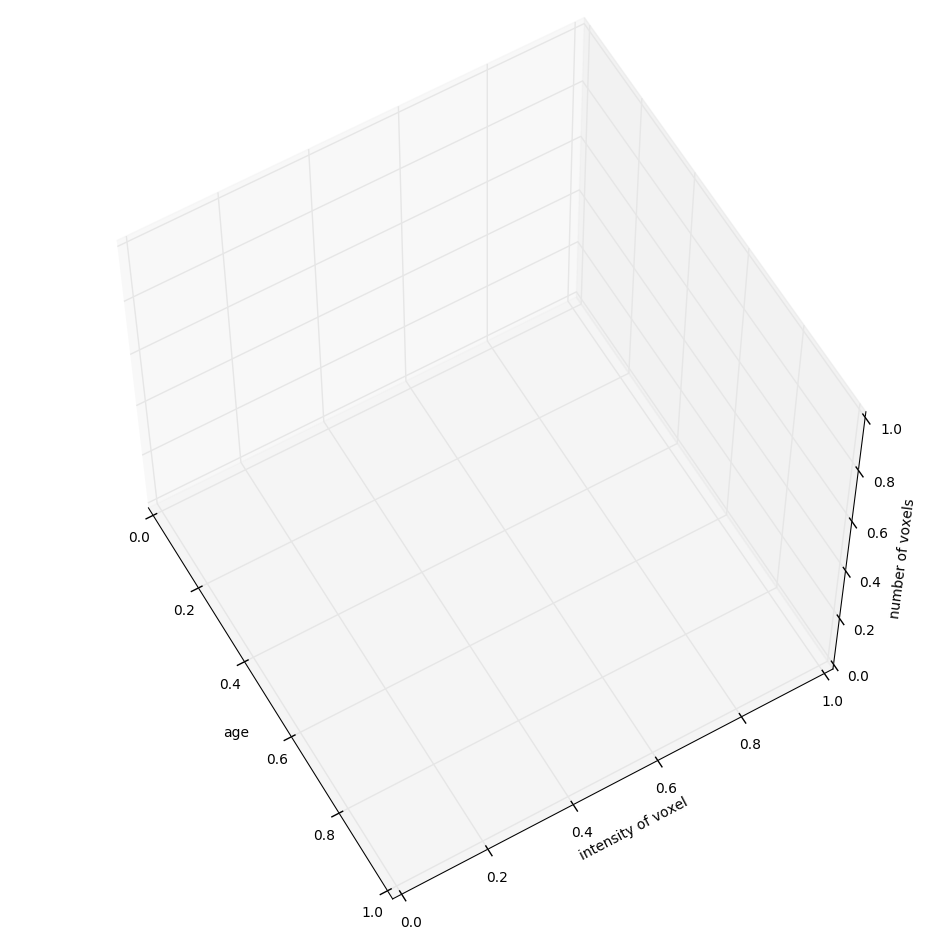

In [83]:
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt

plt.clf()
fig = plt.figure()
fig.set_size_inches(12,12)
ax = fig.gca(projection='3d')
tr = np.arange(0,len(bins))
maxZ = 8400
minZ = -7000
def zo(f):
    h = (f-minZ)/float(maxZ-minZ)
    e = float(4)
    g = max(min(h*e+(1-e)/2,1),0)
    return [g,0.6,1-g,0.5]
k = 50
for i in range(0,n_max,35):
    i=sortI[i]
    print "i=%s..."%i
    Z = x[i,5:]-df # Nvoxels
    Y = bins# intensity
    X = tr*0+y[i] # age
    for j in range(0,len(X)-k):
        ax.plot(X[j:j+k],Y[j:j+k],Z[j:j+k],linewidth=0.1,c=zo(Z[j+(k/2)]))
ax.set_xlabel("age")
ax.set_ylabel("intensity of voxel")
ax.set_zlabel("number of voxels")
ax.view_init(elev=60, azim=330)
#fig.savefig("all-histograms-by-age.png")
plt.show()

In [30]:
print y

[20 25 61 84 23 69 83 62 72 52 52 25 19 70 26 83 83 73 22 21 30 30 18 68 24
 22 65 80 64 24 87 80 81 72 23 24 70 66 22 34 82 25 23 19 20 25 23 23 71 20
 86 81 40 57 76 84 20 18 81 74 80 41 50 88 71 82 35 23 88 54 44 87 80 49 48
 44 21 65 78 84 48 22 43 21 31 23 76 39 89 21 69 60 85 23 71 48 75 78 89 51
 55 22 73 20 74 48 18 71 78 48 74 26 75 94 49 84 22 90 26 81 55 80 19 20 22
 77 75 37 20 72 77 29 69 74 74 64 80 22 90 28 21 20 85 82 71 70 21 78 87 28
 46 79 24 54 24 51 80 78 72 93 89 75 89 58 50 58 22 96 73 78 28 45 18 91 20
 83 43 78 71 59 83 73 64 69 20 20 28 86 72 90 68 90 22 67 84 48 67 78 21 54
 20 22 73 20 27 77 72 86 33 65 31 19 65 50 27 73 50 19 80 80 88 55 54 72 26
 80 41 81 77 79 19 71 89 88 68 20 54 23 22 43 21 86 81 80 22 74 55 21 20 63
 51 45 46 22 23 80 73 84 58 20 83 67 38 26 26 77 69 24 22 26 23 20 54 25 55
 22 23 25]
